Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

# Data Provided

**Features**

`DateCrawled` — date profile was downloaded from the database\
`VehicleType` — vehicle body type\
`RegistrationYear` — vehicle registration year\
`Gearbox` — gearbox type\
`Power` — power (hp)\
`Model` — vehicle model\
`Mileage` — mileage (measured in km due to dataset's regional specifics)\
`RegistrationMonth` — vehicle registration month\
`FuelType` — fuel type\
`Brand` — vehicle brand\
`NotRepaired` — vehicle repaired or not\
`DateCreated` — date of profile creation\
`NumberOfPictures` — number of vehicle pictures\
`PostalCode` — postal code of profile owner (user)\
`LastSeen` — date of the last activity of the user

**Target**

`Price` — price (Euro)

In [1]:
# importing libraries

import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from catboost import Pool, CatBoostRegressor
import time
import matplotlib.pyplot as plt

## Data preparation

### Importing Dataset

In [2]:
nb_time_begin = time.time()

In [3]:
df = pd.read_csv('/datasets/car_data.csv')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Dealing with Missing Values

There is a large, roughly 30% chunk of data missing from the 'NotRepaired' column. Since there is no way of gracefully recovering "yes" or "no" data, I will fill the missing values with "Unknown". 

In [6]:
df['NotRepaired'] = df['NotRepaired'].fillna('Unknown')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

That looks better. I will try dropping the rest of the missing values. 

In [8]:
df = df.dropna()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284126 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        284126 non-null  object
 1   Price              284126 non-null  int64 
 2   VehicleType        284126 non-null  object
 3   RegistrationYear   284126 non-null  int64 
 4   Gearbox            284126 non-null  object
 5   Power              284126 non-null  int64 
 6   Model              284126 non-null  object
 7   Mileage            284126 non-null  int64 
 8   RegistrationMonth  284126 non-null  int64 
 9   FuelType           284126 non-null  object
 10  Brand              284126 non-null  object
 11  NotRepaired        284126 non-null  object
 12  DateCreated        284126 non-null  object
 13  NumberOfPictures   284126 non-null  int64 
 14  PostalCode         284126 non-null  int64 
 15  LastSeen           284126 non-null  object
dtypes: int64(7), object(

In [10]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,284126.000000,284126.000000,284126.000000,284126.000000,284126.000000,284126.0,284126.000000
mean,4847.265516,2002.567861,117.727213,128261.651521,6.071577,0.0,51094.901026
std,4637.056831,6.243808,169.107292,36739.971043,3.548155,0.0,25775.683653
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30851.000000
50%,3199.000000,2003.000000,109.000000,150000.000000,6.000000,0.0,50170.000000
75%,6999.000000,2007.000000,147.000000,150000.000000,9.000000,0.0,71706.000000
max,20000.000000,2018.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Looks like we have some additional clean-up that needs to be done.

* Power has values of 0, which doesn't make sense. A working, sell-able vehicle would not have 0 horsepower.
* There are some instances of Price being 0 - it seems unlikely that someone would give a car away for free and still record it.
* NumberOfPictures is 0 for every single value - this is a useless column, it should be dropped. 
* RegistrationMonth is an int and will be included in the calculations - higher month doesn't mean anything, this should be removed.
* Postal code is an int and will be included in the calculations - this is useless as well. 
* RegistrationYear could be dropped in favor of a better indicator, such as 'VehicleAge', by subtracting RegistrationYear from 2024

In [11]:
# calculating how many instances of Price = 0 there are
print((df['Price'] == 0).sum())

5041


In [12]:
df = df[df['Price'] != 0]

In [13]:
# calculating how many instances of Price = 0 there are
print((df['Price'] == 0).sum())

0


In [14]:
# calculating how many instances of Power < 10 there are
print((df['Power'] < 10).sum())

15280


15000 instances of 0 horsepower would be a pretty big chunk to drop again, but with the way HP can vary between brands and models, it is likely smarter to drop these, if the end goal is an accurate model. 

In [15]:
df = df[df['Power'] >= 10]

In [16]:
# calculating how many instances of Power < 10 there are
print((df['Power'] < 10).sum())

0


In [17]:
# Creating VehicleAge column

df['VehicleAge'] = 2024 - df['RegistrationYear']

In [18]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,VehicleAge
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,Unknown,14/03/2016 00:00,0,90480,05/04/2016 12:47,20
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40,23
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17,16
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17,29
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18,20


In [19]:
# dropping RegistrationYear, RegistrationMonth, NumberOfPictures, PostalCode 

nonsense_cols = ['RegistrationYear', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode']

df = df.drop(nonsense_cols, axis=1)

In [20]:
df.describe()

,Price,Power,Mileage,VehicleAge
count,263805.000000,263805.000000,263805.000000,263805.000000
mean,5069.660723,124.771198,127902.238396,21.195375
std,4664.487570,169.729979,36721.136023,6.134571
min,1.000000,10.000000,5000.000000,6.000000
25%,1499.000000,80.000000,125000.000000,17.000000
50%,3490.000000,115.000000,150000.000000,21.000000
75%,7399.000000,150.000000,150000.000000,25.000000
max,20000.000000,20000.000000,150000.000000,114.000000


In [21]:
# dropping additional columns with dates, as they don't help our modeling

df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

Left with 263k values for modeling - that should be sufficient.

### Splitting into Training and Testing sets

In [22]:
# Defining features and targets for training

features = df.drop('Price', axis=1)
target = df['Price']

In [23]:
# splitting initial train/test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

In [24]:
# splitting train set into a train/valid set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(138497, 9)
(138497,)
(46166, 9)
(46166,)
(79142, 9)
(79142,)


## Model training

In [26]:
# initializing some dictionaries for model evaluation later

rmse_scores_dict = {'Lreg':[], 'RF':[], 'LGBM':[], 'XGB':[], 'CatBoost':[]}
training_time_dict = {'Lreg':[], 'RF':[], 'LGBM':[], 'XGB':[], 'CatBoost':[]}
predict_time_dict = {'Lreg':[], 'RF':[], 'LGBM':[], 'XGB':[], 'CatBoost':[]}

### RMSE Scoring Function

In [27]:
# defining a scoring function, to take predictions and targets, and return RMSE
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [28]:
# creating a scorer object to use the final_sMAPE function to score

rmse = make_scorer(rmse_score, greater_is_better=False)

### One-Hot Encoding

In [29]:
# One-Hot encoding the data for regression

df_ohe = pd.get_dummies(df, drop_first=True)

In [30]:
features_ohe = df_ohe.drop('Price', axis=1)
target_ohe = df_ohe['Price']

In [31]:
# splitting initial train/test set
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(features_ohe, target_ohe, test_size=0.3, random_state=1)

# splitting train set into a train/valid set
X_train_ohe, X_val_ohe, y_train_ohe, y_val_ohe = train_test_split(X_train_ohe, y_train_ohe, test_size=0.25, random_state=1)

In [32]:
display('X_train_ohe shape:', X_train_ohe.shape)
display('y_train_ohe shape:', y_train_ohe.shape)
display('X_val_ohe shape:', X_train_ohe.shape)
display('y_val_ohe shape:', y_train_ohe.shape)
display('X_test_ohe shape:', X_test_ohe.shape)
display('y_test_ohe shape:', y_test_ohe.shape)

'X_train_ohe shape:'

(138497, 305)

'y_train_ohe shape:'

(138497,)

'X_val_ohe shape:'

(138497, 305)

'y_val_ohe shape:'

(138497,)

'X_test_ohe shape:'

(79142, 305)

'y_test_ohe shape:'

(79142,)

### Linear Regression

Beginning with Linear Regression to have as a baseline comparison to the future models. If our gradient boosted models have an RMSE score worse than the LR model, then we know something is incorrect and should be investigated.

In [33]:
start_time = time.time()

lreg = LinearRegression().fit(X_train_ohe, y_train_ohe)

end_time = time.time()
lreg_train_time = end_time - start_time

start_time = time.time()

lreg_preds = lreg.predict(X_test_ohe)

end_time = time.time()
lreg_pred_time = end_time - start_time

lreg_rmse = rmse_score(y_test_ohe, lreg_preds)

print(f'RMSE Score of Linear Regression is: {lreg_rmse}')

rmse_scores_dict['Lreg'].append(lreg_rmse)
training_time_dict['Lreg'].append(lreg_train_time)
predict_time_dict ['Lreg'].append(lreg_pred_time)

RMSE Score of Linear Regression is: 2640.883611962878


That is quite a high RMSE value. Linear Regression does not seem to do very well for this task. But now we have a baseline for future models to compare to.

### Random Forest Regressor

In [34]:
%%time
# using RandomizedSearchCV to optimize hyperparameters 



param_dist = {
    'n_estimators': randint(2, 10),
    'max_depth': randint(2, 6),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 4)
}

rf = RandomForestRegressor()

rf_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=20, cv=3,
                              random_state=1, scoring=rmse)
start_time = time.time()

rf_search.fit(X_train_ohe, y_train_ohe)

end_time = time.time()

rf_train_time = end_time - start_time


# Get the best parameters
print("Best parameters found: ", rf_search.best_params_)

# Get the best score
print("Best score found: ", rf_search.best_score_)


Best parameters found:  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 9}
Best score found:  -2309.244147825318
CPU times: user 2min 41s, sys: 5.23 s, total: 2min 47s
Wall time: 2min 48s


In [35]:
best_rf = rf_search.best_estimator_

start_time = time.time()

y_pred_rf = best_rf.predict(X_test_ohe)

end_time = time.time()

rf_pred_time = end_time - start_time

rf_score = rmse_score(y_test, y_pred_rf)

print("Tuned Random Forest with test data RMSE:", rf_score)

rmse_scores_dict['RF'].append(rf_score)
training_time_dict['RF'].append(rf_train_time)
predict_time_dict ['RF'].append(rf_pred_time)

Tuned Random Forest with test data RMSE: 2320.954768994983


Better than the baseline model by over 300 Euros, that's a start. We'll check some boosting models next. 

### LightGBM

In [36]:
categoricals = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

# copying the X_train and X_test datasets to not edit them directly
X_train_cat = X_train.copy()
X_val_cat = X_val.copy()
X_test_cat = X_test.copy()

X_train_cat[categoricals] = X_train[categoricals].astype('category')
X_val_cat[categoricals] = X_val[categoricals].astype('category')
X_test_cat[categoricals] = X_test[categoricals].astype('category')

In [37]:
# loading features into LightGBM dataset
train_data = lgb.Dataset(X_train_cat, label=y_train, categorical_feature=categoricals, free_raw_data=False)
val_data = lgb.Dataset(X_val_cat, label=y_val, categorical_feature=categoricals, free_raw_data=False)
test_data = lgb.Dataset(X_test_cat, label=y_test, categorical_feature=categoricals, free_raw_data=False)

In [38]:
%%time
params = {'metric': 'rmse',
         'seed': 1}

callbacks = [lgb.early_stopping(10, verbose=True), lgb.log_evaluation(period=-1)]

num_round = 1000

gbm = lgb.train(params, train_data, num_round, valid_sets=[val_data], callbacks=callbacks)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 138497, number of used features: 9
[LightGBM] [Info] Start training from score 5076.742009
Training until validation scores don't improve for 10 rounds


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[593]	valid_0's rmse: 1543.79
CPU times: user 16.2 s, sys: 176 ms, total: 16.4 s
Wall time: 16.6 s


In [39]:
%%time
# lowering learning rate and increasing boosting rounds to increase accuracy
params = {'metric': 'rmse',
          'learning_rate': 0.05,
          'seed': 1}

num_round2 = 2000

start_time = time.time()

gbm2 = lgb.train(params, train_data, num_round2, valid_sets=[val_data], callbacks=callbacks)

end_time = time.time()

gbm_train_time = end_time - start_time

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 138497, number of used features: 9
[LightGBM] [Info] Start training from score 5076.742009
Early stopping, best iteration is:
[593]	valid_0's rmse: 1543.79
CPU times: user 13.1 s, sys: 90 ms, total: 13.2 s
Wall time: 13.4 s


In [40]:
start_time = time.time()

y_pred_gbm = gbm2.predict(X_test_cat)

end_time = time.time()

gbm_pred_time = end_time - start_time

gbm_rmse_score = rmse_score(y_test, y_pred_gbm)

print("Tuned LightGBM with test data RMSE:", gbm_rmse_score)

rmse_scores_dict['LGBM'].append(gbm_rmse_score)
training_time_dict['LGBM'].append(gbm_train_time)
predict_time_dict ['LGBM'].append(gbm_pred_time)

Tuned LightGBM with test data RMSE: 1522.86437831724


Stopped at the same iteration with the same RMSE as the model above. Seems the adjustment in learning rate didn't affect it. Good place to stop. This is significantly better than the random forest model. The first attempt at gradiant boosting lowers the RMSE by nearly 33%. Let's try a couple different gradiant boosting libraries and compare. 

### XGBoost

In [41]:
# loading features into XGBoost DMatrix

dtrain = xgb.DMatrix(X_train_cat, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val_cat, label=y_val, enable_categorical=True)
dtest = xgb.DMatrix(X_test_cat, label=y_test, enable_categorical=True)

In [42]:
%%time
# starting with default hyperparameters

params = {'eval_metric': 'rmse',
         'seed': 1
         }

num_round_xgb = 500

xgboost = xgb.train(params, dtrain, num_round_xgb, evals=[(dval, 'eval')], verbose_eval=False)

CPU times: user 1min 43s, sys: 452 ms, total: 1min 44s
Wall time: 1min 45s


In [43]:
%%time
y_pred_xgb = xgboost.predict(dtest)
print('XGBoost RMSE Score:', rmse_score(y_test, y_pred_xgb))

XGBoost RMSE Score: 1620.3475498055727
CPU times: user 1.74 s, sys: 3.34 ms, total: 1.75 s
Wall time: 1.72 s


In [44]:
%%time
# tuning hyperparameters
params = {
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0,
    'verbosity': 0,
    'seed': 1
}

num_round_xgb = 1000

start_time = time.time()

xgboost2 = xgb.train(params, dtrain, num_round_xgb, evals=[(dval, 'eval')],
                  early_stopping_rounds=10, verbose_eval=False)

end_time = time.time()

xgb_train_time = end_time - start_time

CPU times: user 1min 19s, sys: 184 ms, total: 1min 19s
Wall time: 1min 20s


In [45]:
start_time = time.time()

y_pred_xgb = xgboost2.predict(dtest)

end_time = time.time()

xgb_pred_time = end_time - start_time

xgb_rmse_score = rmse_score(y_test, y_pred_xgb)

print('Tuned XGBoost RMSE Score:', xgb_rmse_score)

rmse_scores_dict['XGB'].append(xgb_rmse_score)
training_time_dict['XGB'].append(xgb_train_time)
predict_time_dict ['XGB'].append(xgb_pred_time)

Tuned XGBoost RMSE Score: 1609.8263533660395


Using XGBoost results in somewhat similar RMSE scores, but it is drastically slower than LightGBM. Moving on to CatBoost.

### CatBoost

In [46]:
# establishing CatBoost Pools


train_pool = Pool(X_train, y_train, cat_features = categoricals)
test_pool = Pool(X_test, cat_features = categoricals)

In [47]:
%%time
# establishing CatBoost regressor

catboost = CatBoostRegressor(iterations=500, eval_metric='RMSE', verbose=False, random_seed=1)

catboost.fit(train_pool)

y_preds_catboost = catboost.predict(test_pool)

print("RMSE of default CatBoost is:", rmse_score(y_test, y_preds_catboost))

RMSE of default CatBoost is: 1579.7344261421326
CPU times: user 1min 55s, sys: 297 ms, total: 1min 56s
Wall time: 1min 56s


In [48]:
%%time

# catboost with tuned hyperparameters

catboost2 = CatBoostRegressor(
    learning_rate=0.1,
    depth=6,
    iterations=1000, 
    early_stopping_rounds=10,  
    eval_metric='RMSE',
    verbose=False,
    random_seed = 1
)

start_time = time.time()

catboost2.fit(train_pool)

end_time = time.time()

catboost_train_time = end_time - start_time

start_time = time.time()

y_preds_catboost2 = catboost2.predict(test_pool)

end_time = time.time()

catboost_pred_time = end_time - start_time

catboost_rmse_score = rmse_score(y_test, y_preds_catboost2)



print("RMSE of Tuned CatBoost is:", catboost_rmse_score)

rmse_scores_dict['CatBoost'].append(catboost_rmse_score)
training_time_dict['CatBoost'].append(catboost_train_time)
predict_time_dict ['CatBoost'].append(catboost_pred_time)

RMSE of Tuned CatBoost is: 1562.8978970428598
CPU times: user 3min 52s, sys: 450 ms, total: 3min 52s
Wall time: 3min 53s


Interestingly, CatBoost has similar performance and takes longer than XGBoost. 

## Model analysis

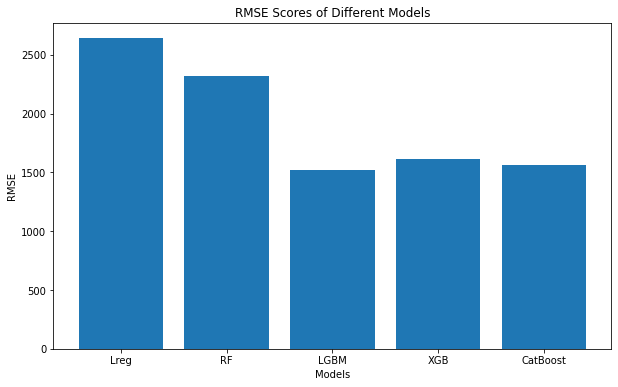

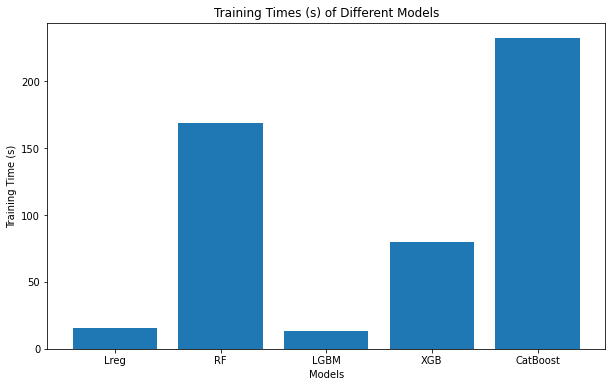

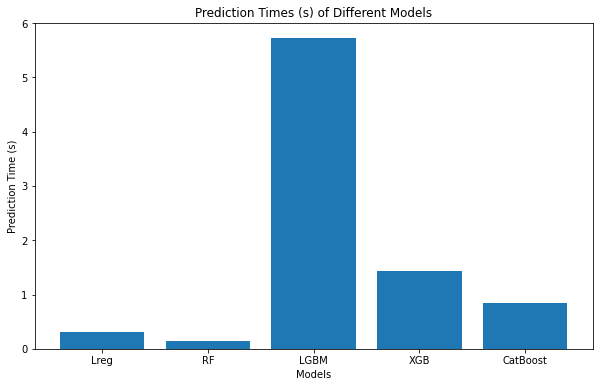

In [49]:
labels = list(rmse_scores_dict.keys())

values = [val[0] for val in rmse_scores_dict.values()]

# RMSE Scores
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Scores of Different Models')
plt.show()

# Training time
labels = list(training_time_dict.keys())

values = [val[0] for val in training_time_dict.values()]

plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xlabel('Models')
plt.ylabel('Training Time (s)')
plt.title('Training Times (s) of Different Models')
plt.show()

# Prediction time

labels = list(predict_time_dict.keys())

values = [val[0] for val in predict_time_dict.values()]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xlabel('Models')
plt.ylabel('Prediction Time (s)')
plt.title('Prediction Times (s) of Different Models')
plt.show()

In [50]:
nb_time_end = time.time()

notebook_time = nb_time_end - nb_time_begin

In [51]:
print(f'Total notebook runtime: {round(notebook_time / 60, 1)} minutes ')

Total notebook runtime: 12.7 minutes 


## Conclusion

After training and evaluating model models, some including gradient boosting and some not, I have come to a conclusion for the best model, based on the parameters of Quality, Training Speed and Prediction time. 

The most successful model in terms of those parameters would be the **Light GBM gradient boosting model**. It had the lowest RMSE, indicating it made the most accurate predictions. It had a significantly lower training speed than any other model aside from linear regression. While its prediction time was technically higher than the rest, it only took 8 seconds. Any other model either took much longer in training, or the quality just wasn't there. 

---

Throughout this project, I have demonstrated the following abilities:

* Taking the provided dataset and preparing it for modeling
* Training various models, both gradient boosted and not, and evaluating them on the requested parameters: quality, training time and prediction time
* Analyzed the results of the model evaluations
* Suggested a final model that met the criteria requested

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed